<a href="https://colab.research.google.com/github/Acilya/inz/blob/master/task_duration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
runOnColab = True
if runOnColab:
  # mount drive
  from google.colab import drive
  drivePath = '/content/drive'
  drive.mount(drivePath)
  !mkdir -p drive
  drivePath += '/My Drive'
else:
  drivePath = ''

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from numpy import genfromtxt
import numpy as np
import pandas as pd
from sklearn import preprocessing

df_original = pd.read_csv(drivePath + '/userStories.csv', sep=';',header=0)
df = df_original.copy(deep=True)
df.head()

,Project,Key,Title,Description,Summary,Priority,Assignee,Reporter,Version,Story points,Created,Resolved,In Progress,Time in sec
0,APSTUD,APSTUD-4183,Support rbenv usage,"<p>I\'m using aptana studio 3 in my mac, osx l...",Support rbenv usage,Critical,cwilliams,nebiros,Aptana Studio 3.0.7,20.0,2012-01-18 21:56:20,2012-01-20 12:32:39,2012-01-26 09:56:41,138979.0
1,APSTUD,APSTUD-4281,As a developer I want to be able to turn on an...,<p>We need some way to turn off validators ind...,As a developer I want to be able to turn on an...,Critical,cwilliams,cwilliams,2012 Sprint 02,40.0,2012-01-26 06:41:55,2012-01-31 12:05:54,2012-01-27 07:30:34,362120.0
2,APSTUD,APSTUD-2816,"Convert ""New From Template"" menu to create ""Un...","<p>Currently, the ""File &gt; New From Template...","Convert ""New From Template"" menu to create ""Un...",High,mxia,ingo,NaN,1.0,2011-06-29 02:14:12,2011-07-13 15:36:29,2011-07-12 17:01:26,81303.0
3,APSTUD,APSTUD-3699,"""Mark Occurrences"" freezes IDE on large files",<p>Steps to reproduce:</p><ol>\t<li>Copy ext-a...,"""Mark Occurrences"" freezes IDE on large files",High,cwilliams,ingo,NaN,1.0,2011-10-20 08:36:49,2011-10-27 06:26:13,2011-10-26 06:10:07,87366.0
4,APSTUD,APSTUD-3368,Add console.debug selector to default themes,NaN,Add console.debug selector to default themes,High,ingo,mstepanov,Aptana Studio 3.0.5,1.0,2011-08-24 05:09:50,2011-08-24 12:37:53,NaN,26883.0


In [ ]:
df.describe()

,Story points,Time in sec
count,10139.000000,1.013900e+04
mean,5.096293,5.047195e+06
std,5.960597,1.403254e+07
min,1.000000,0.000000e+00
25%,2.000000,1.553920e+05
50%,4.000000,9.546480e+05
75%,6.000000,3.361527e+06
max,105.000000,1.559840e+08


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10139 entries, 0 to 10138
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Project       10139 non-null  object 
 1   Key           10139 non-null  object 
 2   Title         10139 non-null  object 
 3   Description   8754 non-null   object 
 4   Summary       10139 non-null  object 
 5   Priority      1234 non-null   object 
 6   Assignee      9722 non-null   object 
 7   Reporter      10138 non-null  object 
 8   Version       156 non-null    object 
 9   Story points  10139 non-null  float64
 10  Created       10139 non-null  object 
 11  Resolved      10139 non-null  object 
 12  In Progress   6593 non-null   object 
 13  Time in sec   10139 non-null  float64
dtypes: float64(2), object(12)
memory usage: 1.1+ MB


In [ ]:
for c in df.columns:
  print(c, 'unique', len(df[c].unique()) / len(df))

Project unique 0.0005917743367195976
Key unique 0.9964493539796824
Title unique 0.9751454778577769
Description unique 0.847026333957984
Summary unique 0.9760331393628563
Priority unique 0.0009862905611993293
Assignee unique 0.02258605385146464
Reporter unique 0.021994279514745044
Version unique 0.004339678469277049
Story points unique 0.01410395502515041
Created unique 0.9964493539796824
Resolved unique 0.9844166091330506
In Progress unique 0.6475983824834797
Time in sec unique 0.9241542558437715


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


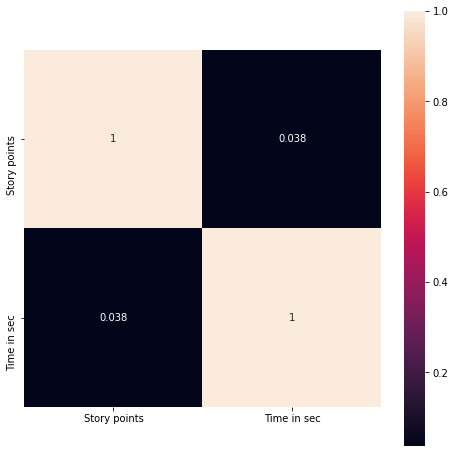

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
column_names = ['Project', 'Key', 'Title', 'Description', 'Summary', 'Priority', 'Assignee', 'Reporter', 'Version', 'Story points', 'In Progress', 'Created', 'Resolved', 'In Progress', 'Time in sec']
f, ax = plt.subplots(figsize=(8, 8))
corr = df[column_names].corr()
sns.heatmap(corr, mask=np.zeros_like(df.corr(), dtype=np.bool),
            square=True, ax=ax,annot=True)

Wnioski:
- Atrybuty 'In Progress', 'Resolved', 'Created' muszą zostać usunięte, ponieważ dotyczą elementu czasowego, który mamy przewidzieć.
- Atrybuty 'Version' i 'Priority' są bardzo rzadke ( < 10% ), więc prawdopodobnie warto się ich pozbyć. Nie są informatywne.
- Jest tylko jeden atrybut liczbowy - 'Story Points'.
- Nie zauważamy specjalnej korelacji pomiędzy atrybutem "Story points" a czasem wykonania zadania.

- Czas trwania zadania jest różnicą pomiędzy rozpoczęciem, a zakończeniem, bez uwzględnienia innych zadań w między czasie! Mediana to ok. 263 godziny, czyli ok 10 dób, co na zadania informatyczne jest dużą liczbą!
  Np. zadanie: "Put simulator and ATHexpod into a docker container" trwało 2 miesiące.


# Część pierwsza (bez analizy semantycznej tytułów i opisów zadań)
- Random Forest
- SVM

In [ ]:
# remove rare data
df_rf = df.copy(deep=True)
df_rf = df_rf.drop(['Priority', 'Title', 'Description', 'Summary', 'Version', 'In Progress', 'Resolved', 'Created'], axis=1)
df_rf.columns

Index(['Project', 'Key', 'Assignee', 'Reporter', 'Story points',
       'Time in sec'],
      dtype='object')

In [ ]:
# clear data
df_rf['Story points'].fillna(0, inplace=True)
# regularization
df_rf['Story points'] = df_rf['Story points'] / max(df_rf['Story points'])
df_rf.fillna('', inplace=True)

In [ ]:
x_rf_train = df_rf.iloc[:, 0:5].values.tolist()
y_rf_train = df_rf.iloc[:, 5:6].values / 3600   #change time to hours
print(len(x_rf_train))
print(len(y_rf_train))
print('mean of hours spent on task', y_rf_train.mean())

10139
10139
mean of hours spent on task 1401.9986922335097


In [ ]:
# encode text attributes
enc = preprocessing.OrdinalEncoder()
enc.fit(x_rf_train)

y_rf_train = y_rf_train.ravel()
x = enc.transform(x_rf_train)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
regressor = RandomForestRegressor(n_estimators = 5, random_state = 0, criterion='mae') 
regressor.fit(x, y_rf_train) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import mean_absolute_error
y_pred = regressor.predict(x)
#print(np.sqrt(np.square(np.subtract(y_rf_train, y_pred))).mean())
print(mean_absolute_error(y_rf_train, y_pred))
print(y_rf_train)
print(y_pred)

607.0516546585791
[ 38.60527778 100.58888889  22.58416667 ... 448.47972222 865.25638889
 213.65916667]
[ 50.88877778  87.25111111  36.56611111 ... 835.10233333 863.62066667
 465.22405556]


# SVM

In [ ]:
from sklearn.svm import SVR
regressor_svm = SVR() 
regressor_svm.fit(x, y_rf_train) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred = regressor_svm.predict(x)
#print(np.sqrt(np.square(np.subtract(y_rf_train, y_pred))).mean())
print(mean_absolute_error(y_rf_train, y_pred))
print(y_rf_train)
print(y_pred)

1328.5742193838303
[ 38.60527778 100.58888889  22.58416667 ... 448.47972222 865.25638889
 213.65916667]
[272.54319891 272.64018943 272.02211006 ... 270.04525081 271.52366153
 273.62009134]


In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (1, 5, 10, 50, 100, 1000),
        },
        cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], criterion='mae', random_state=0, verbose=False)
    rfr.fit(X, y)
    y_pred = rfr.predict(X)
    print(mean_absolute_error(y, y_pred))
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return scores

scores = (-1) * rfr_model(x, y_rf_train)
print(max(scores), min(scores))

1230.0231867028854
1975.4480877972278 695.88799413215


Wnioski
- Za miarę jakości rozwiązania przyjęto Mean Square Error, ze względu na to, że mamy do czynienia z regresją.
- Random Forest osiąga błąd rzędu 600h
- SVM ok. 1300h
- Strojenie parametrów obu metod nie polepsza wyników na tyle, aby mogły być uznane jako zadowalające dla tego problemu. 
- Problem: jakość danych

# Część druga (przetwarzanie języka naturalnego, analiza tytułów i opisów)

In [ ]:
# !pip install gensim
# !pip install nltk
# !pip install tensorflow 
# !pip install keras

In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import re
import nltk
import nltk.stem
import gensim
from nltk.corpus import stopwords
from spacy.lang import en
from spacy.lang.en.examples import sentences
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

simple_prepocessing:

*   usunięcie wszystkich fragmentów kodu html takich jak "< p >", "< li >"
*   usunięcie nadmiernej ilości spacji
*   usunięcie cyfr

Wypadałoby dodać:

*   usunięcie linków
*   Sprawdzanie czy cyfyr w tytule są ważne



In [ ]:
porter = PorterStemmer()

In [ ]:
def simple_preprocessing(text):
  text = re.sub(r'<[a-z]>', '', text)
  text = re.sub(r'^[a-zA-Z]+', ' ', text)
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
  text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = re.sub(r'\^"', '', text)
  text = re.sub(r'"$', '', text)
  text = re.sub(r'<.*?>', '', text)
  text = text.lower()
  return text

In [ ]:
nlpdf = df.copy(deep=True)
nlpdf

,Project,Key,Title,Description,Summary,Priority,Assignee,Reporter,Version,Story points,Created,Resolved,In Progress,Time in sec
0,APSTUD,APSTUD-4183,rbenv usage,"<p>I\'m using aptana studio 3 in my mac, osx l...",Support rbenv usage,Critical,cwilliams,nebiros,Aptana Studio 3.0.7,20.0,2012-01-18 21:56:20,2012-01-20 12:32:39,2012-01-26 09:56:41,138979.0
1,APSTUD,APSTUD-4281,developer want to be able to turn on and off ...,<p>We need some way to turn off validators ind...,As a developer I want to be able to turn on an...,Critical,cwilliams,cwilliams,2012 Sprint 02,40.0,2012-01-26 06:41:55,2012-01-31 12:05:54,2012-01-27 07:30:34,362120.0
2,APSTUD,APSTUD-2816,files by default,"<p>Currently, the ""File &gt; New From Template...","Convert ""New From Template"" menu to create ""Un...",High,mxia,ingo,NaN,1.0,2011-06-29 02:14:12,2011-07-13 15:36:29,2011-07-12 17:01:26,81303.0
3,APSTUD,APSTUD-3699,freezes ide on large files,<p>Steps to reproduce:</p><ol>\t<li>Copy ext-a...,"""Mark Occurrences"" freezes IDE on large files",High,cwilliams,ingo,NaN,1.0,2011-10-20 08:36:49,2011-10-27 06:26:13,2011-10-26 06:10:07,87366.0
4,APSTUD,APSTUD-3368,console.debug selector to default themes,NaN,Add console.debug selector to default themes,High,ingo,mstepanov,Aptana Studio 3.0.5,1.0,2011-08-24 05:09:50,2011-08-24 12:37:53,NaN,26883.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10134,DM,DM-1551,htm-based spatial binning to visualize large ...,<p>Currently we are using a generic 2-d binnin...,Prototype HTM-based spatial binning to visuali...,NaN,tatianag,tatianag,NaN,16.0,2014-11-20 15:10:24,2015-02-27 16:05:16,2015-01-16 11:26:36,3645520.0
10135,DM,DM-1544,up git hub for ipac firefly,NaN,Set up GIT hub for ipac firefly,NaN,roby,roby,NaN,18.0,2014-11-18 17:09:56,2014-12-25 20:02:28,NaN,3207152.0
10136,DM,DM-1782,existing fits reader class needs to be refact...,"<ul class=""alternate"" type=""square"">\t<li>FITS...",The existing FITS reader class needs to be ref...,NaN,zhang,xiuqin,NaN,16.0,2015-01-15 16:51:50,2015-02-03 09:20:37,NaN,1614527.0
10137,DM,DM-1652,existing fits reader class needs to be refact...,"<ul class=""alternate"" type=""square"">\t<li>chec...",The existing FITS reader class needs to be ref...,NaN,zhang,zhang,NaN,16.0,2014-12-10 15:31:38,2015-01-15 16:47:01,NaN,3114923.0


In [ ]:
titles = nlpdf['Title']
titles

0                                              rbenv usage
1         developer want to be able to turn on and off ...
2                                         files by default
3                               freezes ide on large files
4                 console.debug selector to default themes
                               ...                        
10134     htm-based spatial binning to visualize large ...
10135                          up git hub for ipac firefly
10136     existing fits reader class needs to be refact...
10137     existing fits reader class needs to be refact...
10138     /learn what others are doing in astronomy sof...
Name: Title, Length: 10139, dtype: object

In [ ]:
desc = nlpdf['Description']
desc

0        <p>I\'m using aptana studio 3 in my mac, osx l...
1        <p>We need some way to turn off validators ind...
2        <p>Currently, the "File &gt; New From Template...
3        <p>Steps to reproduce:</p><ol>\t<li>Copy ext-a...
4                                                      NaN
                               ...                        
10134    <p>Currently we are using a generic 2-d binnin...
10135                                                  NaN
10136    <ul class="alternate" type="square">\t<li>FITS...
10137    <ul class="alternate" type="square">\t<li>chec...
10138    <p>Attend the annual  ADASS conference to keep...
Name: Description, Length: 10139, dtype: object

In [ ]:
titles

0                                             rbenv usage
1        developer want to be able to turn on and off ...
15       ability to specify jslint settings on global ...
17                       js plugin into core and ui parts
22       common meta-programming idioms that define me...
                              ...                        
1081                          usergrid graduation process
1091     master to two-dot-o branches & rewrite tests ...
1120     creation when using s3binarystore doesn't fun...
1208     occuring when clicking link to activate organ...
1210     data migration format lifecycle on initial setup
Name: Title, Length: 86, dtype: object

Preprocessing tytułów za pomocą wyrażeń regularnych, a także stemmizacji


In [ ]:
title_processed = []
for title in titles:
  title_processed.append(porter.stem(simple_preprocessing(title)))
# title_processed

Zamiana sekund na godziny

In [ ]:
time = nlpdf['Time in sec']
time /= 3600
time

0          38.605278
1         100.588889
2          22.584167
3          24.268333
4           7.467500
            ...     
10134    1012.644444
10135     890.875556
10136     448.479722
10137     865.256389
10138     213.659167
Name: Time in sec, Length: 10139, dtype: float64

Przykładowe tworzenie etykiet

In [ ]:
y = []
for t in time:
  if t < 10:
    y.append(0)
  elif t >= 10 and t < 50:
    y.append(1)
  elif t >= 50 and t < 500:
    y.append(2)
  else:
    y.append(3)

Normalizacja czasu

In [ ]:
m = time.mean()
s = time.std()
time = (time - m) / s

Trenowanie z wykorzystaniem CountVectorizera

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import *
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(title_processed)
X = vectorizer.transform(title_processed).toarray()
X.shape

(10139, 7661)

In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

Model regresyjny o małej pojemności bazujący na samych tytułach tasków, korzystający z CountVectorizera, bez używania word embeddings

In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

Train on 9125 samples, validate on 1014 samples
Epoch 1/10
9125/9125 [==============================] - 1s 83us/step - loss: 17609006.2603 - val_loss: 13096058.3679
Epoch 2/10
9125/9125 [==============================] - 1s 73us/step - loss: 17608004.7671 - val_loss: 13094694.3895
Epoch 3/10
9125/9125 [==============================] - 1s 75us/step - loss: 17606068.0274 - val_loss: 13092114.2086
Epoch 4/10
9125/9125 [==============================] - 1s 75us/step - loss: 17602343.3973 - val_loss: 13087633.5459
Epoch 5/10
9125/9125 [==============================] - 1s 74us/step - loss: 17596247.3425 - val_loss: 13080371.7668
Epoch 6/10
9125/9125 [==============================] - 1s 75us/step - loss: 17586560.0000 - val_loss: 13069431.5187
Epoch 7/10
9125/9125 [==============================] - 1s 74us/step - loss: 17572649.5685 - val_loss: 13053710.0799
Epoch 8/10
9125/9125 [==============================] - 1s 75us/step - loss: 17552675.3493 - val_loss: 13032662.0291
Epoch 9/10
9125/

In [ ]:
model.fit(X, np.array(time), epochs=10, batch_size=1000, validation_split=0.1)

Train on 9125 samples, validate on 1014 samples
Epoch 1/10
9125/9125 [==============================] - 1s 76us/step - loss: 17588147.3014 - val_loss: 13062669.8693
Epoch 2/10
9125/9125 [==============================] - 1s 77us/step - loss: 17529088.4658 - val_loss: 12986479.6055
Epoch 3/10
9125/9125 [==============================] - 1s 76us/step - loss: 17407168.3562 - val_loss: 12843447.2539
Epoch 4/10
9125/9125 [==============================] - 1s 76us/step - loss: 17197319.1507 - val_loss: 12619880.4665
Epoch 5/10
9125/9125 [==============================] - 1s 75us/step - loss: 16897653.9863 - val_loss: 12336543.5251
Epoch 6/10
9125/9125 [==============================] - 1s 76us/step - loss: 16532834.3699 - val_loss: 12037637.0192
Epoch 7/10
9125/9125 [==============================] - 1s 75us/step - loss: 16138965.2329 - val_loss: 11768227.4236
Epoch 8/10
9125/9125 [==============================] - 1s 75us/step - loss: 15779428.5479 - val_loss: 11568569.2125
Epoch 9/10
9125/

Model klasyfikacyjny o małej pojemności bazujący na samych tytułach tasków, korzystający z CountVectorizera, bez używania word embeddings

In [ ]:
mod = Sequential()
mod.add(Dense(100, input_dim=X.shape[1], activation='relu'))
mod.add(Dense(1, activation='relu'))
mod.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
mod.fit(X, y, validation_split=0.5, epochs=1)

Train on 5069 samples, validate on 5070 samples
Epoch 1/1
5069/5069 [==============================] - 2s 374us/step - loss: 1.8977 - accuracy: 0.2304 - val_loss: 1.4829 - val_accuracy: 0.2168


Model  LSTM (tytuły)


In [ ]:
sen = []
for t in title_processed:
  sen.append(str(t))

In [ ]:
from keras.preprocessing import sequence

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sen)
title_sequences = tokenizer.texts_to_sequences(sen)

data = sequence.pad_sequences(title_sequences, maxlen=200)
data

array([[   0,    0,    0, ...,    0, 4000, 1006],
       [   0,    0,    0, ...,   27,  309, 4002],
       [   0,    0,    0, ...,  274,   53,  126],
       ...,
       [   0,    0,    0, ...,    6,  168,   16],
       [   0,    0,    0, ...,    6,  168,   18],
       [   0,    0,    0, ...,    4, 3967, 1000]], dtype=int32)

In [ ]:
X_train = sequence.pad_sequences(X_train, 200)

In [ ]:
X_train

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

In [ ]:
lstm = Sequential()
lstm.add(Embedding(10000, 32, input_length=200))
lstm.add(LSTM(100))
lstm.add(Dense(1, activation='relu'))
lstm.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
lstm.fit(data, np.array(time), epochs=10, batch_size=100, validation_split=0.3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7097 samples, validate on 3042 samples
Epoch 1/10
7097/7097 [==============================] - 25s 4ms/step - loss: 16707923.2810 - val_loss: 18087043.5431
Epoch 2/10
7097/7097 [==============================] - 24s 3ms/step - loss: 16678237.1174 - val_loss: 18062581.5528
Epoch 3/10
7097/7097 [==============================] - 25s 3ms/step - loss: 16658522.8081 - val_loss: 18039418.3245
Epoch 4/10
7097/7097 [==============================] - 25s 3ms/step - loss: 16640013.4308 - val_loss: 18017499.2957
Epoch 5/10
7097/7097 [==============================] - 24s 3ms/step - loss: 16622206.1250 - val_loss: 17995741.2765
Epoch 6/10
7097/7097 [==============================] - 25s 3ms/step - loss: 16604713.6601 - val_loss: 17974842.2763
Epoch 7/10
7097/7097 [==============================] - 25s 3ms/step - loss: 16587472.2952 - val_loss: 17953921.5994
Epoch 8/10
7097/7097 [==============================] - 25s 4ms/step - loss: 16570126.6317 - val_loss: 17932734.0105
Epoch 9/10
7097/

In [ ]:
lstmClass = Sequential()
lstmClass.add(Embedding(5000, 32, input_length=200))
lstmClass.add(LSTM(100))
lstmClass.add(Dense(1, activation='relu'))
lstmClass.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
lstm.fit(data, y, epochs=10, batch_size=10, validation_split=0.3)

Train on 7097 samples, validate on 3042 samples
Epoch 1/10
7097/7097 [==============================] - 97s 14ms/step - loss: 3.0518 - val_loss: 1.5331
Epoch 2/10
7097/7097 [==============================] - 97s 14ms/step - loss: 1.0161 - val_loss: 1.3835
Epoch 3/10
7097/7097 [==============================] - 96s 14ms/step - loss: 0.8807 - val_loss: 1.3918
Epoch 4/10
7097/7097 [==============================] - 98s 14ms/step - loss: 0.7565 - val_loss: 1.5836
Epoch 5/10
7097/7097 [==============================] - 97s 14ms/step - loss: 0.6622 - val_loss: 1.5737
Epoch 6/10
7097/7097 [==============================] - 97s 14ms/step - loss: 0.5858 - val_loss: 1.6101
Epoch 7/10
7097/7097 [==============================] - 100s 14ms/step - loss: 0.5282 - val_loss: 1.6679
Epoch 8/10
7090/7097 [============================>.] - ETA: 0s - loss: 0.4839

In [ ]:
for _ in desc:
  print(_)

<p>I\'m using aptana studio 3 in my mac, osx lion, and I\'m using rbenv to install rubies, but when I try to run the debugger in aptana I always got this error:</p><p>    /Users/nebiros/.rbenv/shims/ruby: line 4: exec: rbenv: not found</p><p>I already set some environment variables in the aptana ruby debug configuration window:</p><p>    RBENV_ROOT: /Users/nebiros/.rbenv <br/>    RUBYLIB: /Users/nebiros/.rbenv/versions/1.9.2-p290/lib/ruby/1.9.1</p><p>I\'m trying to run this command:</p><ul class="alternate" type="square">\t<li>Program: /Users/nebiros/.rbenv/shims/bundle</li>\t<li>Interpreter Arguments: -d</li>\t<li>Program Arguments: exec rake dreadful_dog:process_content --trace &#8211; -f ./assets/test_ssss_content.zip -d /tmp</li>\t<li>Working Directory: /Users/nebiros/Projects/dreadful_dog</li></ul>
<p>We need some way to turn off validators individually, and in particular between build vs reconcile. This stems from the poor performance of the JS validators during large builds. The

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<p>The prototype QA dashboard (<a href="https://jira.lsstcorp.org/browse/DM-10619" title="Build a prototype bokeh server implementation to demonstrate desired interactive QA plots" class="issue-link" data-issue-key="DM-10619"><del>DM-10619</del></a>) was only implemented using one patch-worth of HSC data.  With a factor of ~100 more data (e.g., a whole tract), performance may suffer to the point where qualitatively different solutions for some things may be required, such as perhaps density (or partial-density) plots for the scatter image, which may require different solutions for selection, etc.  This will require re-running <tt>coaddAnalysis.py</tt> again on an HSC tract, saving the data table, and plugging that in as the data in the prototype dashboard.  This ticket should spawn new tickets to solve whatever issues arise from using this larger data set.</p>
<p>At least some of the implementation was in</p><p>$OBS_SUBARU_DIR/python/lsst/obs/subaru/ingest.py</p><p>on the old HSC fork.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



nan
nan
<p>This issue is the implementation for <a href="https://jira.lsstcorp.org/browse/DM-1126" title="design new Footprint API" class="issue-link" data-issue-key="DM-1126"><del>DM-1126</del></a>, including fixing code broken by the API changes.  This issue should be given subtasks for discrete pieces of work as part <a href="https://jira.lsstcorp.org/browse/DM-1126" title="design new Footprint API" class="issue-link" data-issue-key="DM-1126"><del>DM-1126</del></a>, as it has a lot of story points.  Because it\'s likely all of this needs to be merged at the same time, it should probably be done on a single branch, unless some of the earlier work can be done in a backwards-compatible way..</p>
nan
nan
<p>We have a working plan of putting the buildbot-scripts under jenkins demo into usage as a production CI system as an intermediate step towards a fully decomposed build.</p>
nan
<p>Using the PSF simulations generated in <a href="https://jira.lsstcorp.org/browse/DM-1131" title="create 

In [ ]:
for _ in titles:
  print(_)

Streaming output truncated to the last 5000 lines.
 configuration
 rc2 with w_2018_38
 rc2 with w_2018_42
 hits 2014, build template coadds
 sphinx-based task documentation for packages
 draft of task documentation topic-type
 user visible error reporting in qserv with antlr4 parser
 lsst30 dataset to cloud
 k8s and deployment documentation for test deployment in the cloud
 rc2 with w_2018_41
 end users to cancel builds
 pod policies within k8s commons
 using file headers for overscan region definition
 gain measurement from eotest's ptc task with bftask.estimategains()"
 to comparison scripts in pipe_analysis
 message mod
 telemetry queues and proper callbacks for the queues in l1 dm system
 initial telemetry stream to ocs_bridge
  command for dmcs
 rfc-534: update naming of base_blendedness fields
 management of gke persistentdisks
 potential issue with setting of not_deblended mask
 adass butler poster
 machine generating/verifying butler storageclass
 butler quantumgraph
 test case